In [2]:
import sys
sys.path.append("..")

from utils.pickleloader import load_pickle, dump_pickle
import utils.fdt as fdt
import utils.mhue as mhue
import utils.homogeneity as homogeneity
import utils.stability as stability
import utils.match_groundtruth as match_groundtruth
import utils.region as region

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from tqdm.notebook import tqdm
import talib
import pandas as pd
import math
import os
import re
from scipy.stats import gaussian_kde
from scipy.signal import argrelmin,argrelmax
from scipy.ndimage import binary_fill_holes
def crop_image(image):
    x1 = np.min(np.where(image>1)[0])
    x2 = np.max(np.where(image>1)[0])
    y1 = np.min(np.where(image>1)[1])
    y2 = np.max(np.where(image>1)[1])
#     print((x1,x2),(y1,y2))
    return image[x1:x2, y1:y2]

In [238]:
importlib.reload(mhue)

<module 'mhue' from '/home/yk/py/Segmentation/0805BatchTest/mhue.py'>

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 150

Get Scharr gradient value, done.


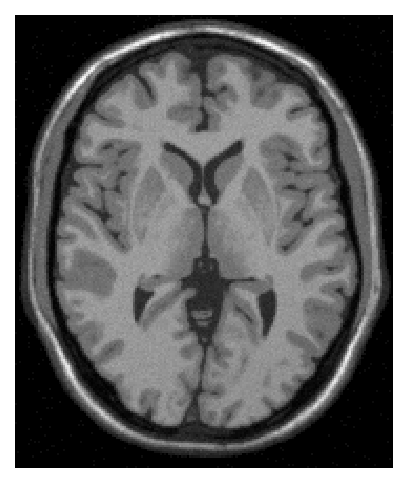

In [4]:
idx = 74

image = cv.imread('../image/t1/outImg'+str(idx)+'.bmp',0)

beta = 10
_,mask = cv.threshold(image,beta,255,0)
mask = binary_fill_holes(mask)
image = image*mask
image = crop_image(image)

plt.axis('off')
plt.imshow(image)

image_denoise = cv.fastNlMeansDenoising(image,templateWindowSize=7,searchWindowSize=27)

scharr = homogeneity.get_scharr(image_denoise)
scharr_n = homogeneity.rank_normalize(scharr)

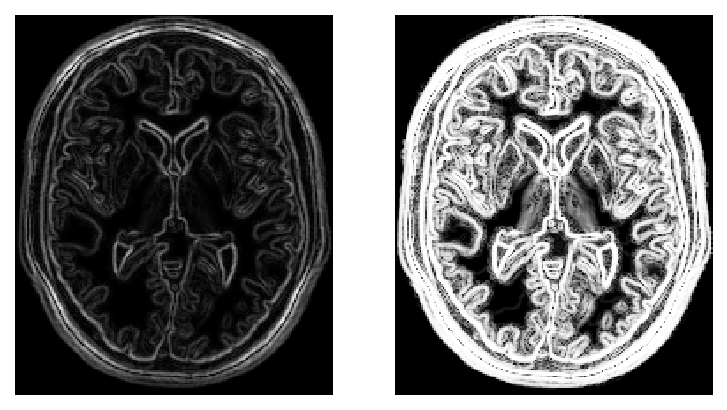

In [5]:
plt.figure()
plt.subplot(121)
plt.axis('off')
plt.imshow(scharr)
plt.subplot(122)
plt.axis('off')
plt.imshow(scharr_n)

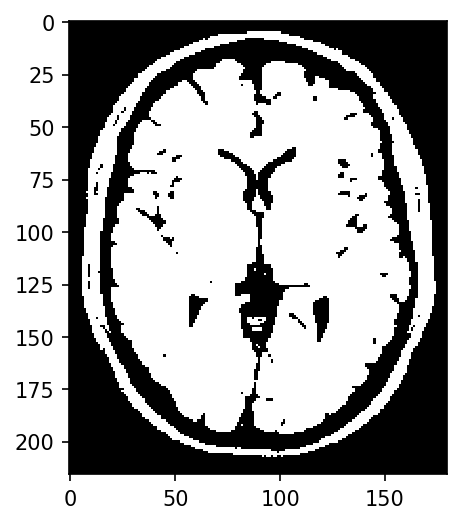

In [6]:
_,test_img = cv.threshold(image,70,255,0)
plt.imshow(test_img)

In [221]:
import time
from scipy.ndimage import distance_transform_cdt
%time
start = time.time()
for t in range(np.min(image)+2,np.max(image)-2):
    _,test_img = cv.threshold(image,t,255,0)
    test_res = distance_transform_cdt(test_img,return_distances=True)

end = time.time()
print(end-start)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 28.6 µs
0.17121171951293945


In [7]:
bdts_o = load_pickle('../pickle/bdts_o'+str(idx)+'.pkl')
bdts_b = load_pickle('../pickle/bdts_b'+str(idx)+'.pkl')
stabs = load_pickle('../pickle/stab'+str(idx)+'.pkl')

In [8]:
uncertainty = mhue.get_uncertainty(image)
mhue_img = mhue.get_HU(uncertainty=uncertainty, homogeneity=scharr_n)
uncertaintyw = mhue.get_uncertainty(image, off_center=True, info_w=True, stabs=stabs, 
                                    bdts_o=bdts_o, bdts_b=bdts_b,kernel_size=21,sigma=0.3)
mhuew_img = mhue.get_HU(uncertainty=uncertaintyw, homogeneity=scharr_n)

../utils/mhue.py:56: RuntimeWarning: divide by zero encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../utils/mhue.py:56: RuntimeWarning: invalid value encountered in true_divide
  p_b = np.exp(-np.power(img - mean_b, 2) / (2 * var_b)) / (math.sqrt(2 * math.pi * var_b))
../utils/mhue.py:70: RuntimeWarning: divide by zero encountered in log
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)
../utils/mhue.py:70: RuntimeWarning: invalid value encountered in multiply
  u = (-mhue_i) * np.log(mhue_i) - (1-mhue_i) * np.log(1-mhue_i)
../utils/mhue.py:67: RuntimeWarning: invalid value encountered in less
  mhue_i[np.where(mhue_i < obj_rate)] = mhue_i[np.where(mhue_i < obj_rate)] / (2*obj_rate)
../utils/mhue.py:68: RuntimeWarning: invalid value encountered in greater_equal
  mhue_i[np.where(mhue_i >= obj_rate)] = (mhue_i[np.where(mhue_i >= obj_rate)]+1-2*obj_rate) / (2-2*obj_rate)


In [246]:
region_img = region.get_score(image,uncertainty=uncertaintyw,homogeneity=scharr_n,kernel_size=7)

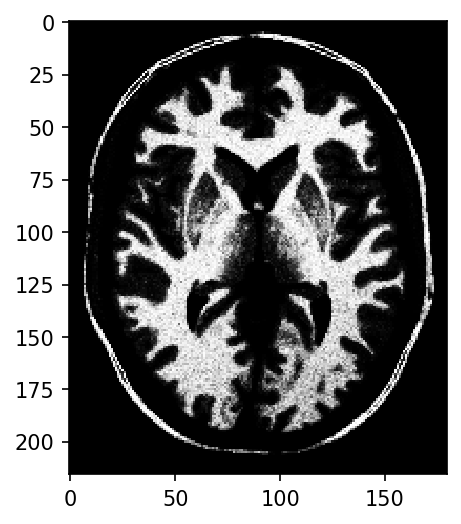

In [9]:
plt.imshow(uncertainty[130].reshape(image.shape))

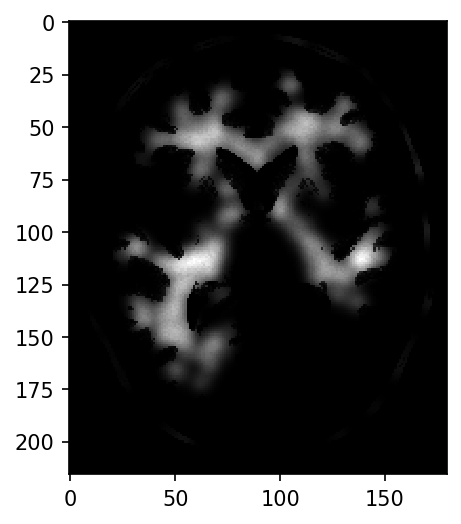

In [10]:
plt.imshow(uncertaintyw[130].reshape(image.shape))

Text(0.5, 1.0, 'Index: 74, Weighted-MHUE')

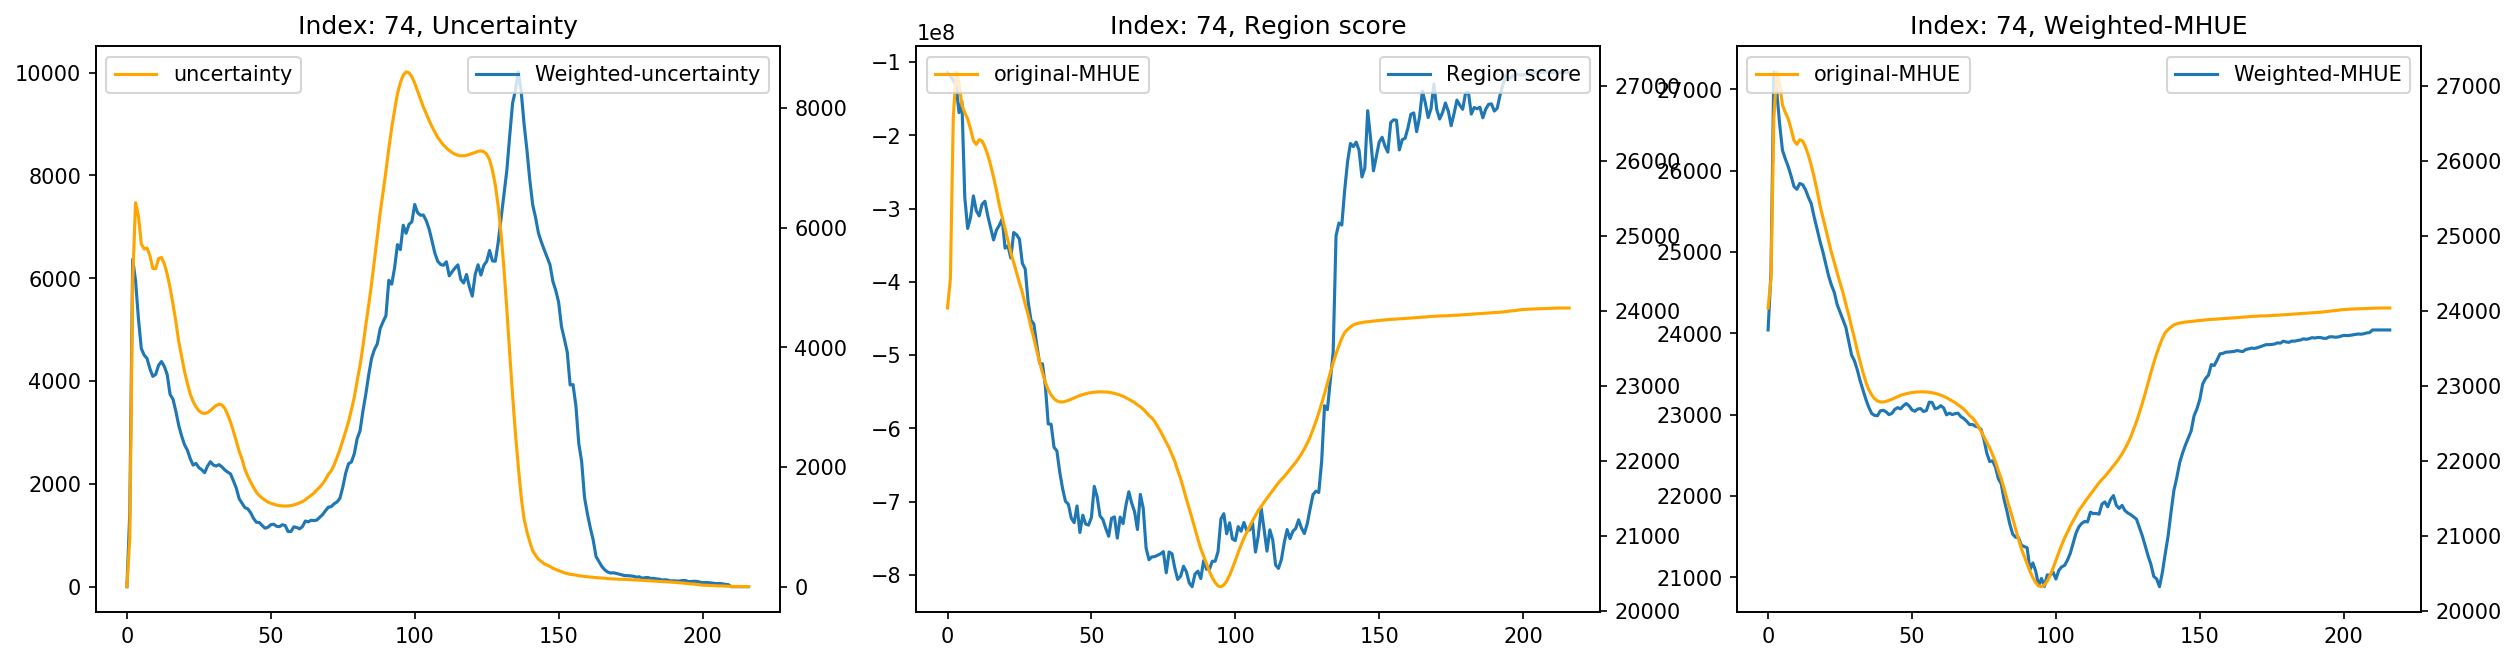

In [237]:
_u = list(map(lambda x:np.sum(x),uncertainty))
_uw = list(map(lambda x:np.sum(x),uncertaintyw))
_e = list(map(lambda x:np.sum(x),mhue_img))
_ew = list(map(lambda x:np.sum(x),mhuew_img))
_r = list(map(lambda x:np.sum(x),region_img))

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
ax2 = ax1.twinx()
ax1.plot(_uw,label='Weighted-uncertainty')
ax1.legend(loc=1)
ax2.plot(_u,color='orange',label='uncertainty')
ax2.legend(loc=2)
plt.title('Index: {}, Uncertainty'.format(str(idx)))

ax3 = fig.add_subplot(132)
ax4 = ax3.twinx()
ax3.plot(_r,label='Region score')
ax3.legend(loc=1)
ax4.plot(_e,color='orange',label='original-MHUE')
ax4.legend(loc=2)
plt.title('Index: {}, Region score'.format(str(idx)))

ax6 = fig.add_subplot(133)
ax7 = ax6.twinx()
ax6.plot(_ew,label='Weighted-MHUE')
ax6.legend(loc=1)
ax7.plot(_e,color='orange',label='original-MHUE')
ax7.legend(loc=2)
plt.title('Index: {}, Weighted-MHUE'.format(str(idx)))

In [193]:
from vmdpy import VMD

alpha = 2000       # moderate bandwidth constraint  
tau = 0.0          # noise-tolerance (no strict fidelity enforcement)  
K = 5              # modes
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7  

y, y_hat, omega = VMD(_r, alpha, tau, K, DC, init, tol)  

473666.31292639964 126703556.48680946 0.01404573276084475
30892430.13371982 126703556.48680946 0.9160601169007314
2310958.6274458542 126703556.48680946 0.06852737130900144
33066.35480742479 126703556.48680946 0.0009805239898335975
13025.735543067414 126703556.48680946 0.0003862550395889994


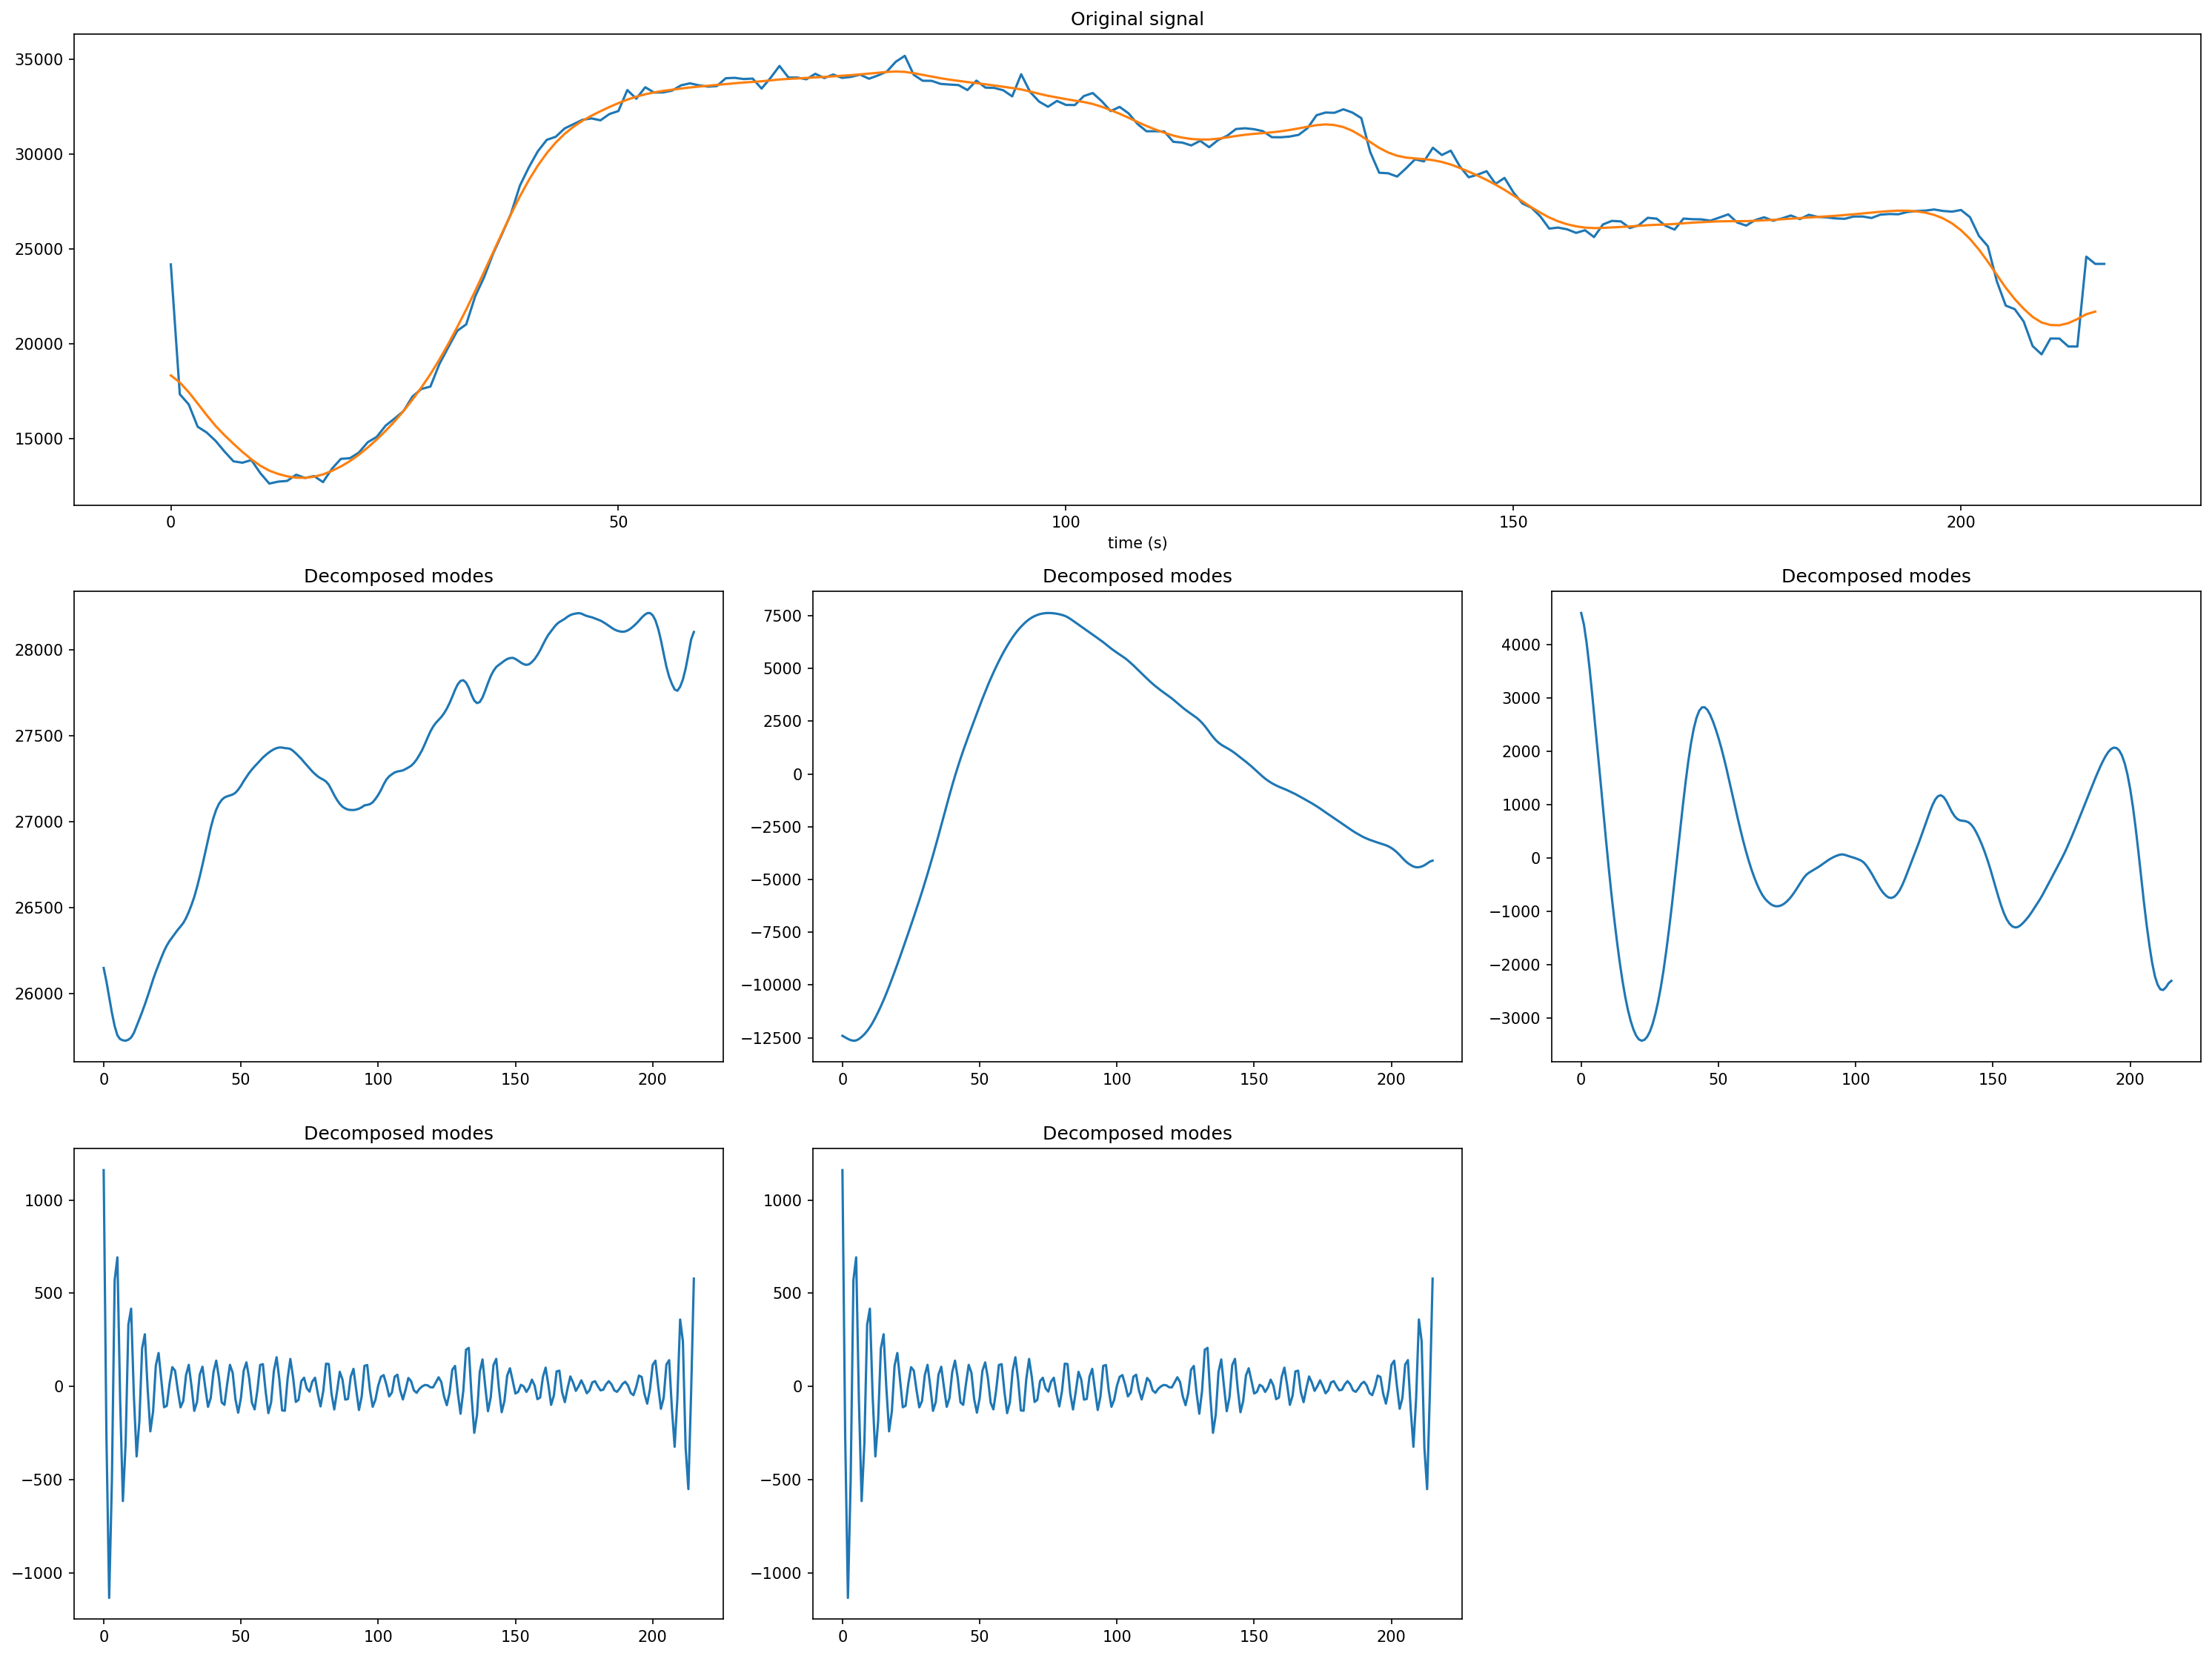

In [195]:
plt.figure(figsize=(20,15))
plt.subplot(311)
plt.plot(_r)
plt.plot(y[0,:]+y[1,:]+y[2,:])
plt.title('Original signal')
plt.xlabel('time (s)')
plt.subplot(334)
plt.plot(y[0,:].T)
plt.title('Decomposed modes')
plt.subplot(335)
plt.plot(y[1,:].T)
plt.title('Decomposed modes')
plt.subplot(336)
plt.plot(y[2,:].T)
plt.title('Decomposed modes')
plt.subplot(337)
plt.plot(y[3,:].T)
plt.title('Decomposed modes')
plt.subplot(338)
plt.plot(y[3,:].T)
plt.title('Decomposed modes')

# plt.legend(['Mode %d'%m_i for m_i in range(y.shape[0])])
plt.tight_layout()

for mode in range(y.shape[0]):
    rate = np.var(y[mode,:])/np.sum(np.var(y,axis=1))
    print(np.var(y[mode,:]),np.var(y),rate)

In [196]:
print(argrelmax(y[0,:]+y[1,:]+y[2,:]))

(array([ 81, 129, 174, 193]),)


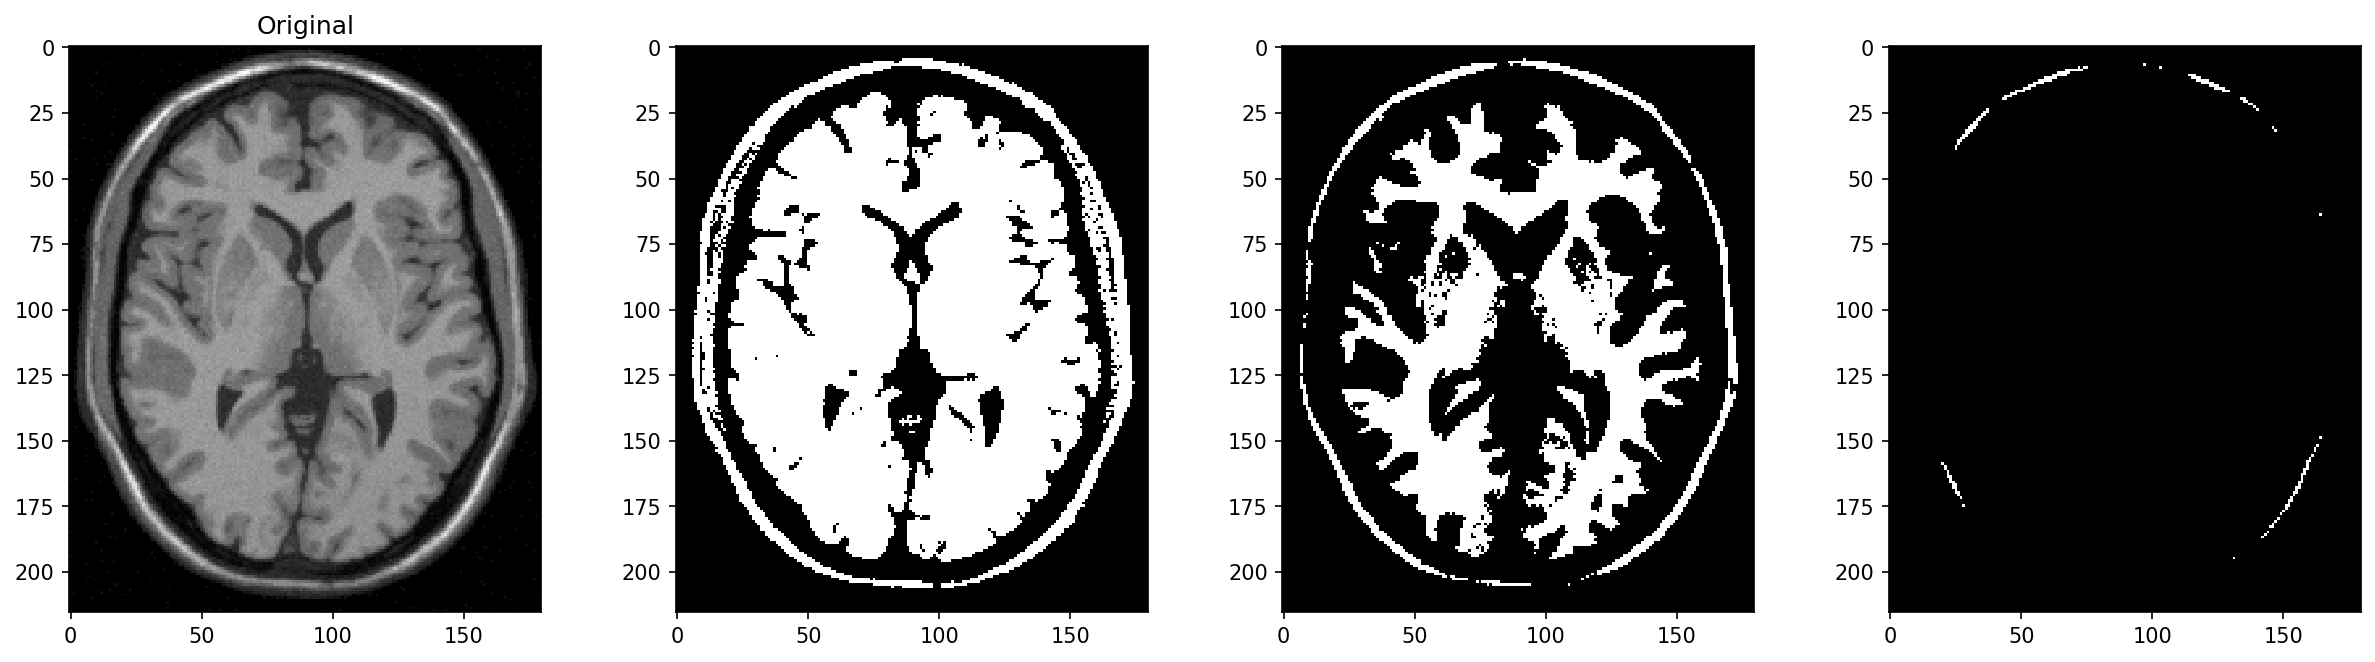

In [217]:
tlower = np.min(image) + 2
t1 = 81 + tlower
t2 = 110 + tlower
t3 = 174 + tlower
t4 = 193 + tlower

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(141)
ax1.imshow(image)
ax1.set_title('Original')
ax2 = fig.add_subplot(142)
_,res1 = cv.threshold(image,t1,255,0)
ax2.imshow(res1)
# ax2.set_title('MHUE')
ax3 = fig.add_subplot(143)
_,res2 = cv.threshold(image,t2,255,0)
ax3.imshow(res2)
# ax3.set_title('Weighted-MHUE')
ax4 = fig.add_subplot(144)
_,res3 = cv.threshold(image,t3,255,0)
ax4.imshow(res3)
# ax4.set_title('Region')

_,res4 = cv.threshold(image,t4,255,0)

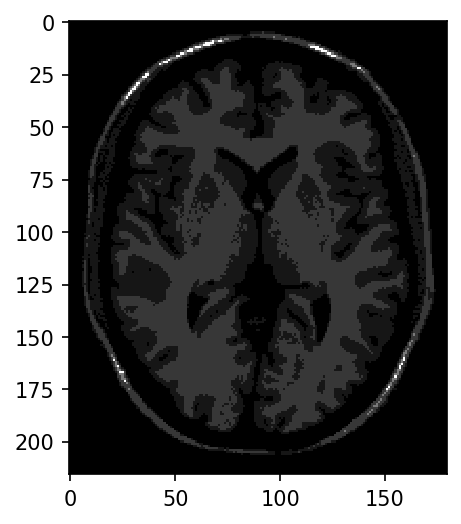

In [218]:
plt.imshow(res1/6+res2/4+res3/2+res4)

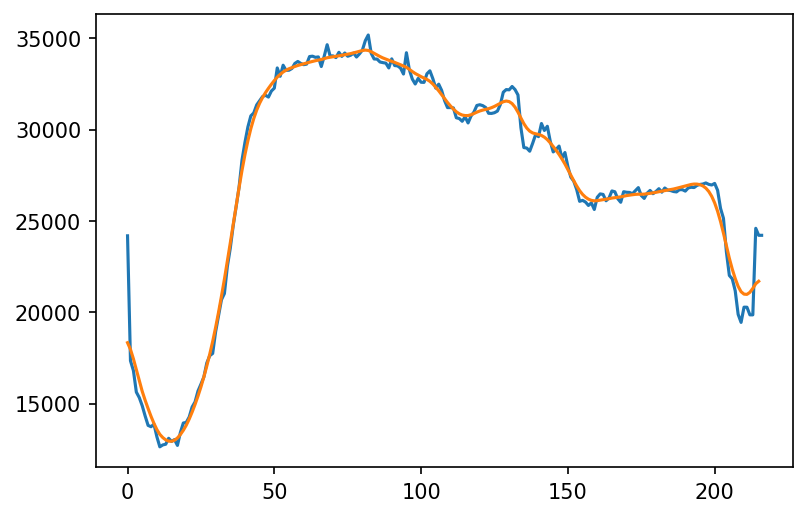

In [199]:
plt.plot(_r)
plt.plot(y[0,:]+y[1,:]+y[2,:])

In [200]:
test_sig = y[0,:]+y[1,:]+y[2,:]
print(argrelmax(test_sig))

(array([ 81, 129, 174, 193]),)


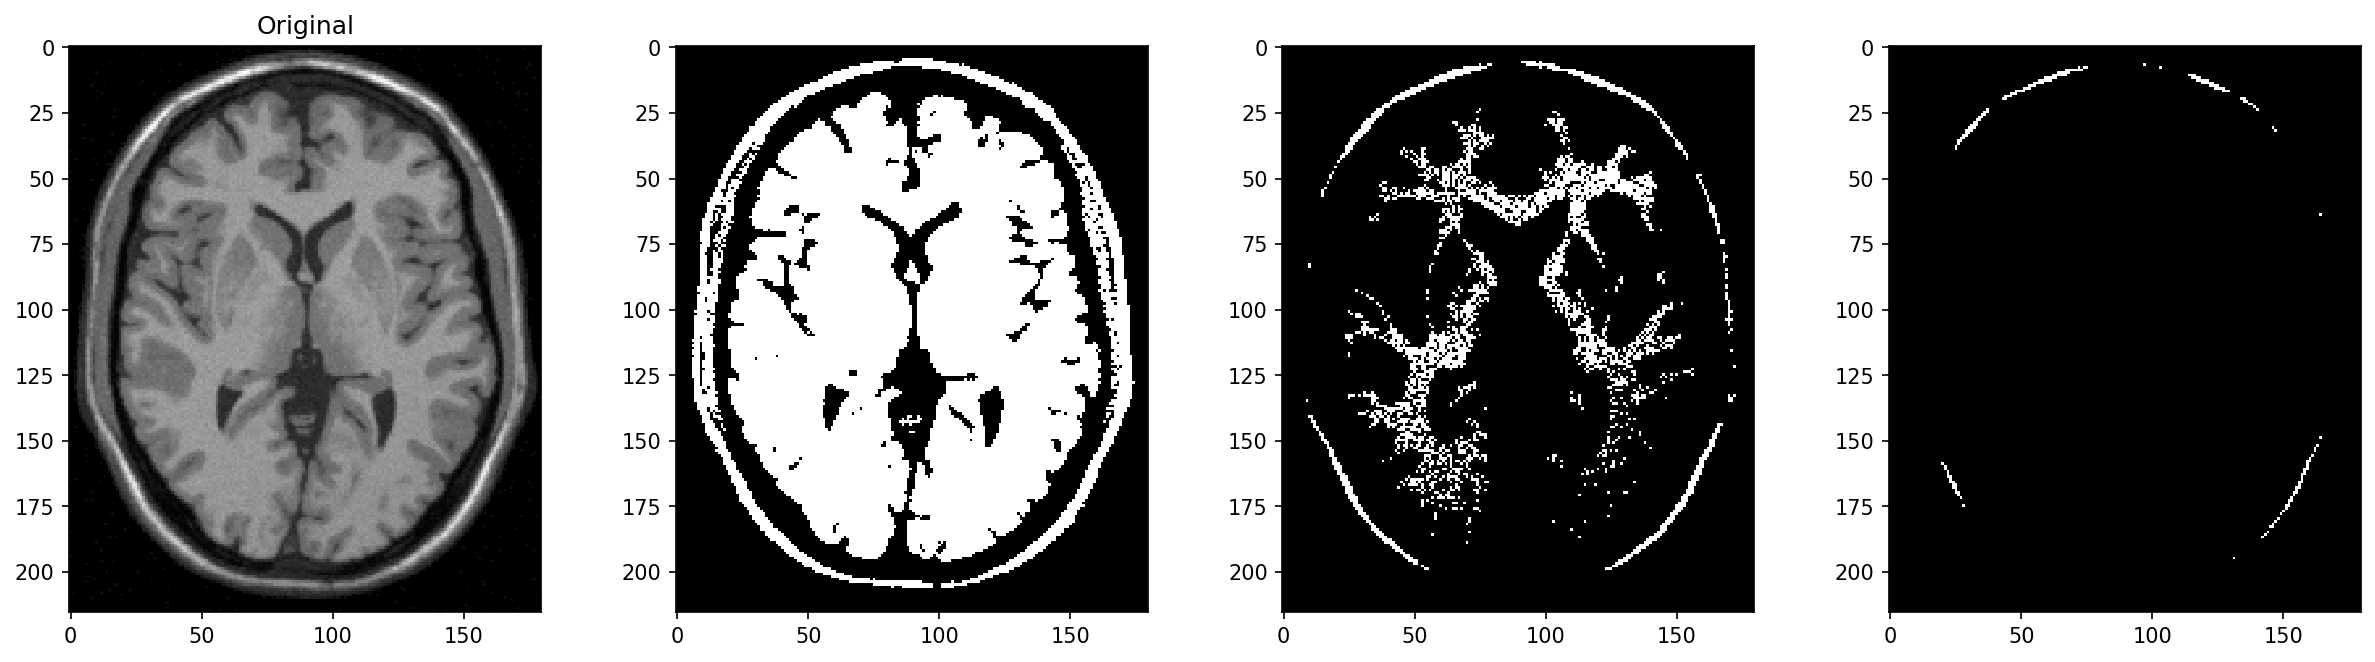

In [201]:
tlower = np.min(image) + 2
t1 = 81 + tlower
t2 = 129 + tlower
t3 = 174 + tlower

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(141)
ax1.imshow(image)
ax1.set_title('Original')
ax2 = fig.add_subplot(142)
_,res = cv.threshold(image,t1,255,0)
ax2.imshow(res)
# ax2.set_title('MHUE')
ax3 = fig.add_subplot(143)
_,tmp = cv.threshold(image,t2,255,0)
ax3.imshow(tmp)
# ax3.set_title('Weighted-MHUE')
ax4 = fig.add_subplot(144)
_,tmp = cv.threshold(image,t3,255,0)
ax4.imshow(tmp)
# ax4.set_title('Region')

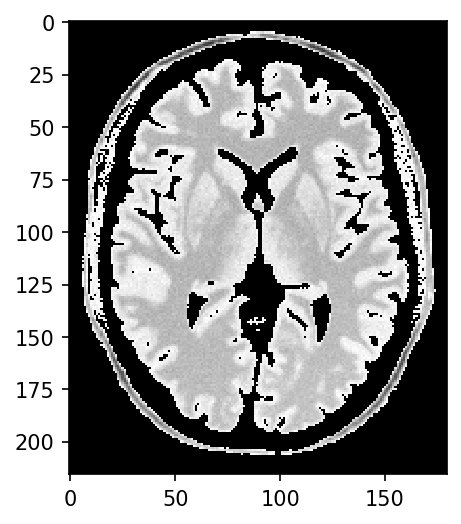

In [202]:
_,mask_r = cv.threshold(image,t1,255,0)
image_r = mask_r * image
plt.imshow(image_r)

In [203]:
uncertainty_r = mhue.get_uncertainty(image_r)

/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yk/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yk/py/Segmentation/0805BatchTest/mhue.py:56: RuntimeWarning: divide by zero encountered in true_divide
  # Gaussian dist
/home/yk/py/Segmentation/0805BatchTest/mhue.py:56: Runti

In [204]:
uncertaintyw_r = mhue.get_uncertainty(image_r, off_center=True, info_w=True, stabs=stabs, 
                                      bdts_o=bdts_o, bdts_b=bdts_b,kernel_size=21, sigma=0.3)

/home/yk/py/Segmentation/0805BatchTest/mhue.py:67: RuntimeWarning: invalid value encountered in less
  # Off-centered Entropy
/home/yk/py/Segmentation/0805BatchTest/mhue.py:68: RuntimeWarning: invalid value encountered in greater_equal
  obj_rate = np.array(np.where(img>=i)[0].size / img.size)


In [205]:
mhue_img_r = mhue.get_HU(uncertainty=uncertainty_r, homogeneity=scharr_n*mask_r)
mhuew_img_r = mhue.get_HU(uncertainty=uncertaintyw_r, homogeneity=scharr_n*mask_r)

In [206]:
region_img_r = region.get_score(image_r,uncertainty=uncertaintyw_r,homogeneity=scharr_n*mask_r,kernel_size=7)

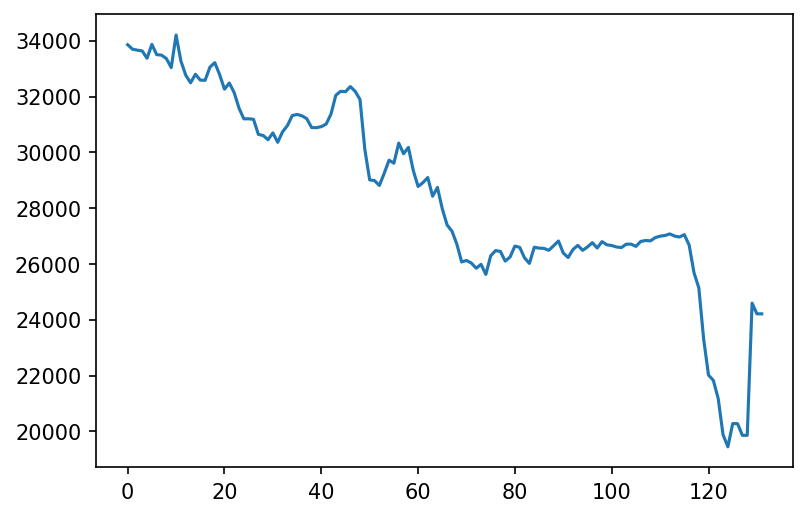

In [207]:
plt.plot(list(map(lambda x:np.sum(x),region_img[t1+tlower:])))

(array([11, 53, 71]),)


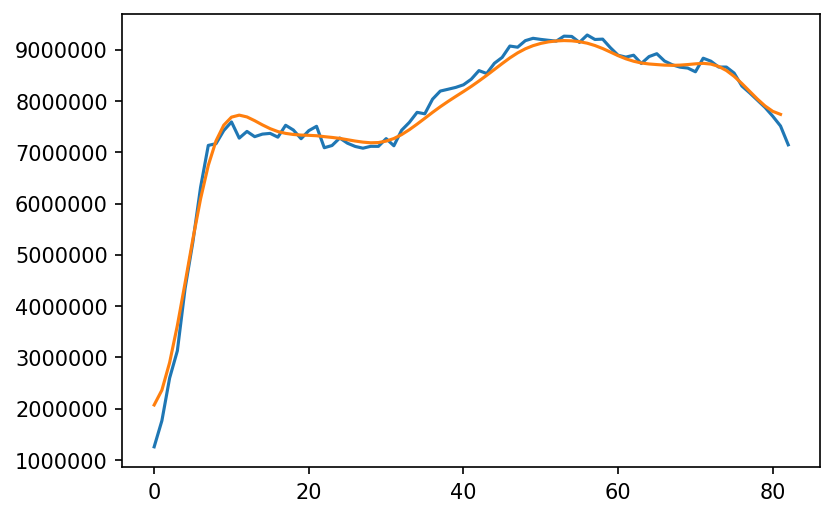

In [212]:
from vmdpy import VMD

_test = list(map(lambda x:np.sum(x),region_img_r[t1+tlower:]))

alpha = 2000       # moderate bandwidth constraint  
tau = 0.            # noise-tolerance (no strict fidelity enforcement)  
K = 5              # 3 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7  


#. Run VMD 
_r_recon_all, _test_recon_hat, omega = VMD(_test, alpha, tau, K, DC, init, tol)
_r_recon = _r_recon_all[0,:].copy()
for mode in range(1,_test_recon.shape[0]):
    if np.var(_r_recon_all[mode,:])/np.sum(np.var(_r_recon_all,axis=1)) > 0.01:
        _r_recon += _r_recon_all[mode,:]

plt.plot(_test)
plt.plot(_r_recon)
print(argrelmax(_r_recon))

In [213]:
11+t1+tlower

96

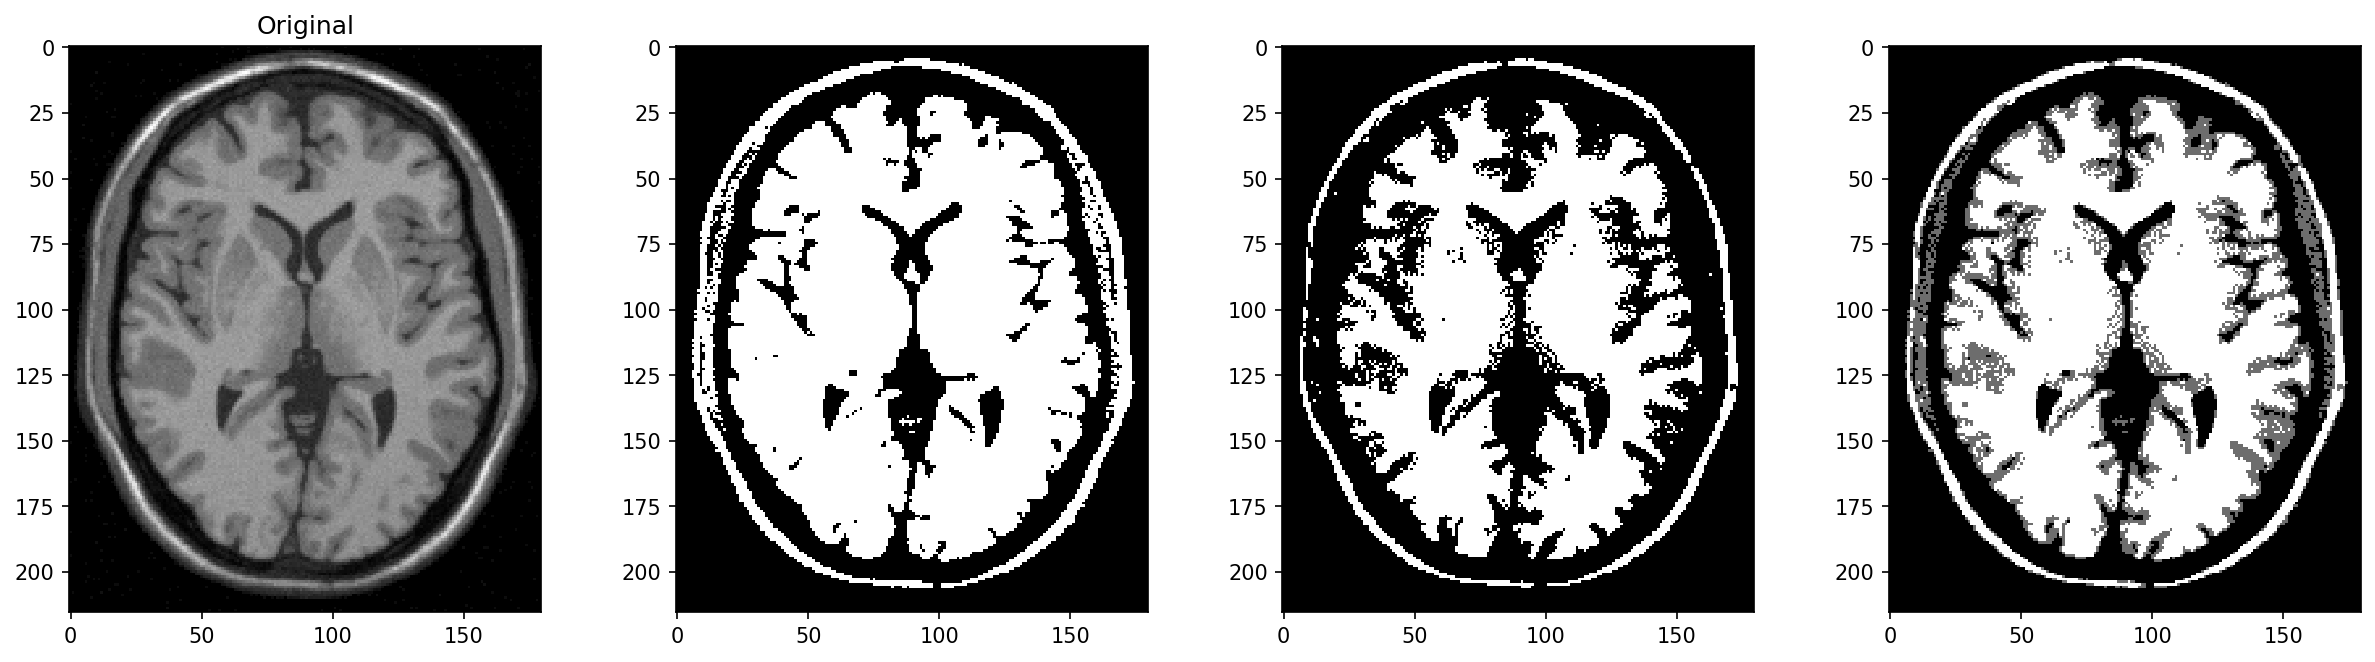

In [214]:
tlower = np.min(image) + 2
t1 = 82 + tlower
t2 = 96 + tlower
t3 = 174 + tlower

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(141)
ax1.imshow(image)
ax1.set_title('Original')
ax2 = fig.add_subplot(142)
_,res = cv.threshold(image,t1,255,0)
ax2.imshow(res)
# ax2.set_title('MHUE')
ax3 = fig.add_subplot(143)
_,tmp = cv.threshold(image,t2,255,0)
ax3.imshow(tmp)
# ax3.set_title('Weighted-MHUE')
ax4 = fig.add_subplot(144)
ax4.imshow(res/4 + tmp/3)
# _,tmp = cv.threshold(image,t3,255,0)
# ax4.imshow(tmp)
# ax4.set_title('Region')

In [169]:
testc = get_score(image,uncertainty,scharr_n)

In [13]:
def get_score(image, uncertainty, homogeneity, kernel_size=7):
    conv = []
    mid_kernel = int(kernel_size/2)
    for i in tqdm(range(len(uncertainty))):
        u = uncertainty[i].reshape(image.shape)
        convoluted = np.zeros(image.shape)
        u_pad = cv.copyMakeBorder(u, mid_kernel, mid_kernel, mid_kernel, mid_kernel, cv.BORDER_REPLICATE)
        scharr_pad = cv.copyMakeBorder(homogeneity, mid_kernel, mid_kernel, mid_kernel, mid_kernel, cv.BORDER_REPLICATE)
        u_rank_all = np.argsort(u_pad, axis=None).reshape(u_pad.shape) + 1
        for m in range(u.shape[0]):
            for n in range(u.shape[1]):
                u_rank = u_rank_all[m:m+2*mid_kernel+1,n:n+2*mid_kernel+1].copy()
                u_rank = u_rank - np.min(u_rank) + 1
                conv_u = u_pad[m:m+2*mid_kernel+1,n:n+2*mid_kernel+1]
#                 u_rank = np.argsort(conv_u, axis=None).reshape(conv_u.shape) + 1
                std = np.std(conv_u)
                kernel_weight = 2*(np.random.normal(loc=0, scale=std**2, size=(kernel_size, kernel_size)) +
                                   u_rank/(kernel_size**2))-1
                convoluted[m, n] = np.sum(kernel_weight*scharr_pad[m:m+2*mid_kernel+1, n:n+2*mid_kernel+1])
        conv.append(convoluted)
    return conv